Analysis Titan's winning 921 blocks.

Author: Bryanzk
Date Modified: 2024.04.11
License: CC0

In [21]:
from data_prep_utils import *
from plot_prep_utils import *

df = get_block_data_with_winning_bids_having_bid_ts()
dft = get_titan_won_921_blocks_bidding_data()
df_builder_info = get_builder_info(df)



/Users/kezheng/temp/mevboost-data/examples/data_prep_utils.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2023-10-10 12:17:46.267000', '2023-10-10 12:17:59.157000',
 '2023-10-10 12:18:11.103000', '2023-10-10 12:18:23.431000',
 '2023-10-10 12:18:35.193000', '2023-10-10 12:18:47.158000',
 '2023-10-10 12:18:59.140000', '2023-10-10 12:19:11.045000',
 '2023-10-10 12:19:23.192000', '2023-10-10 12:19:47.657000',
 ...
 '2024-04-09 18:52:47.037000', '2024-04-09 18:52:59.769000',
 '2024-04-09 18:53:11.636000', '2024-04-09 18:53:23.926000',
 '2024-04-09 18:53:35.903000', '2024-04-09 18:53:59.772000',
 '2024-04-09 18:54:11.705000', '2024-04-09 18:54:23.194000',
 '2024-04-09 18:54:35.642000', '2024-04-09 18:54:47.768000']
Length: 1140830, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df['bid_

In [36]:
# Add builder label to dft
print(dft.columns)
print(df_builder_info.columns)
print("before merge: ", dft.shape[0])
dft = pd.merge(dft, df_builder_info[['builder_pubkey', 'builder_label']], on='builder_pubkey', how='left')
print("after merge: ", dft.shape[0])

Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission', 'ts_diff',
       'ts_diff_secs'],
      dtype='object')
Index(['builder_pubkey', 'builder_label'], dtype='object')
before merge:  1698090
after merge:  1698090


In [2]:
# Filter out the duplicate block_number records with the earliest bid_timestamp, which is the winning bid thru the fastest relay
# N.B.: this would omit the records with the same block_number but different bid_timestamp from differe relays
df_filtered = df.copy()
df_filtered = df_filtered.sort_values(['block_number', 'bid_timestamp_ms'])
df_filtered = df_filtered.drop_duplicates('block_number', keep='first')

# get the unique block numbers won by Titan
unique_block_numbers_won_by_titan = dft['block_number'].unique()

df_filtered_titan = df_filtered[df_filtered['block_number'].isin(unique_block_numbers_won_by_titan)]
# df_filtered_titan.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df_filtered['bid_timestamp_ms'], unit='ms')
print(df_filtered_titan.shape[0])

921


min:-3.0; max:3.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_63135/1104625551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_63135/1104625551.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(0.2, 0.3], (-0.2, -0.1], (0.0, 0.1], (-0.4, -0.3], (-0.7, -0.6], ..., (-0.8, -0.7], (-0.2, -0.1], (-0.7, -0.6], (-0.3, -0.2], (-0.4, -0.3]]
Length: 921
Categories (60, interval[float64, right]): [(-3.0, -2.9] < (-2.9, -2.8] < (-2.8, -2.7] < (-2.7, -2.6] ... (2.6, 2.7] < (2.7, 2.8] < (2.8, 2.9] < (2.9, 3.0]]' has dtype incompatible with category, please explicitly cast to 

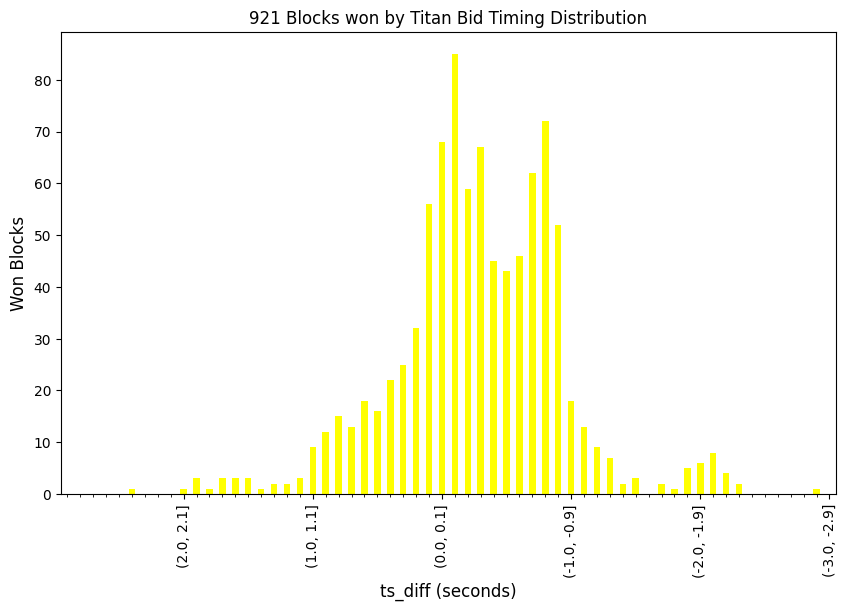

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_63135/1104625551.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_avg = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].mean().reset_index(name='avg_num_tx')
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_63135/1104625551.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_med = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].median().reset_index(name='med_num_tx')


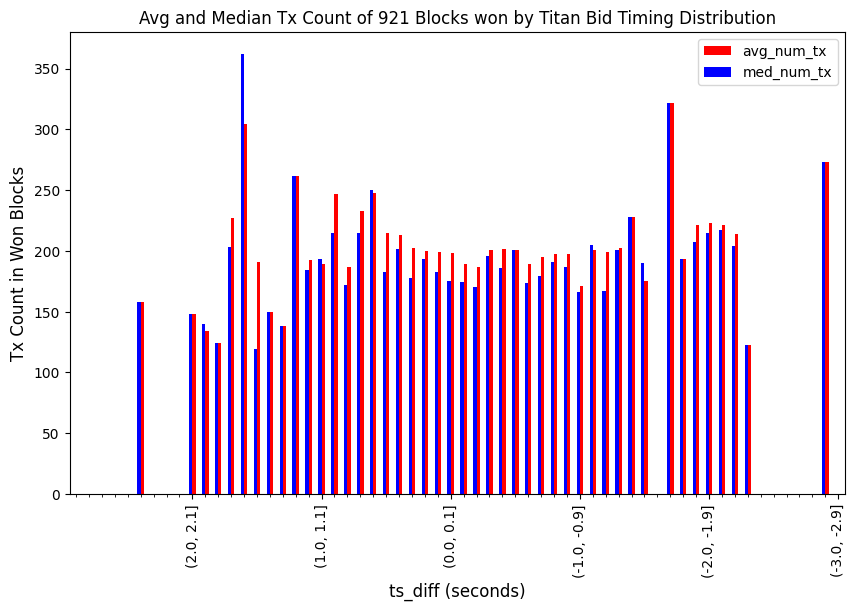

In [3]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


# 计算 ts_diff 的最小和最大值
x_min = np.floor(df_filtered_titan['ts_diff_secs'].min())
x_max = np.ceil(df_filtered_titan['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
    df_filtered_titan['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)


df_filtered_titan.loc[:,'ts_diff_bins'] = df_filtered_titan['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))


grouped = df_filtered_titan.groupby('ts_diff_bins')['block_number'].count()

ax = grouped.plot(kind='bar', figsize=(10,6), color='yellow')

adjust_plot_x_axis(ax)

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Won Blocks', fontsize=12)
plt.title('921 Blocks won by Titan Bid Timing Distribution')

plt.show()

# save the grouped data to clipboard
grouped_transposed = grouped.transpose()
grouped_transposed.to_clipboard(index=True, header=True)

# draw the chart of average and median number of transactions in the blocks won by Titan
grouped_avg = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].mean().reset_index(name='avg_num_tx')
grouped_med = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].median().reset_index(name='med_num_tx')
merged_df = pd.merge(grouped_avg, grouped_med, on='ts_diff_bins')

txplot = merged_df.plot(x='ts_diff_bins', y=['avg_num_tx', 'med_num_tx'], kind='bar', color=['red', 'blue'], figsize=(10,6))
adjust_plot_x_axis(txplot)
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Tx Count in Won Blocks', fontsize=12)
plt.title('Avg and Median Tx Count of 921 Blocks won by Titan Bid Timing Distribution')
# save the grouped data to clipboard
tx_grouped_transposed = merged_df.transpose()
merged_df.to_clipboard(index=True, header=True)



all max ts_diff_secs10.725
all min_ts_diff_secs-11.985
min:-12.0; max:11.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_63135/2096865834.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_63135/2096865834.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(1.3, 1.4], (0.7, 0.8], (0.1, 0.2], (-1.4, -1.3], (-0.5, -0.4], ..., (0.9, 1.0], (-1.5, -1.4], (0.7, 0.8], (1.5, 1.6], (0.9, 1.0]]
Length: 1695372
Categories (230, interval[float64, right]): [(-12.0, -11.9] < (-11.9, -11.8] < (-11.8, -11.7] < (-11.7, -11.6] ... (10.6, 10.7] < (10.7, 10.8] < (10.8, 10.9] < (10.9, 11.0]]' has dtype incompatible with category, please explicitly 

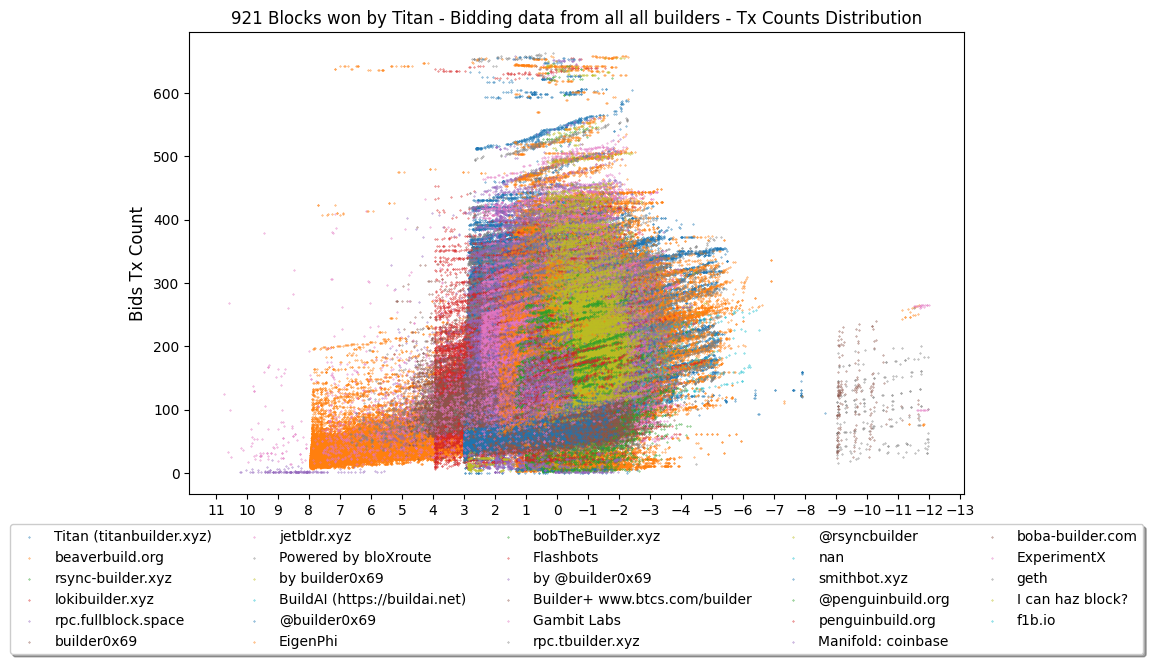

max ts_diff_secs
2.988
min ts_diff_secs
-8.636
all builder 1695372
Titan 524300


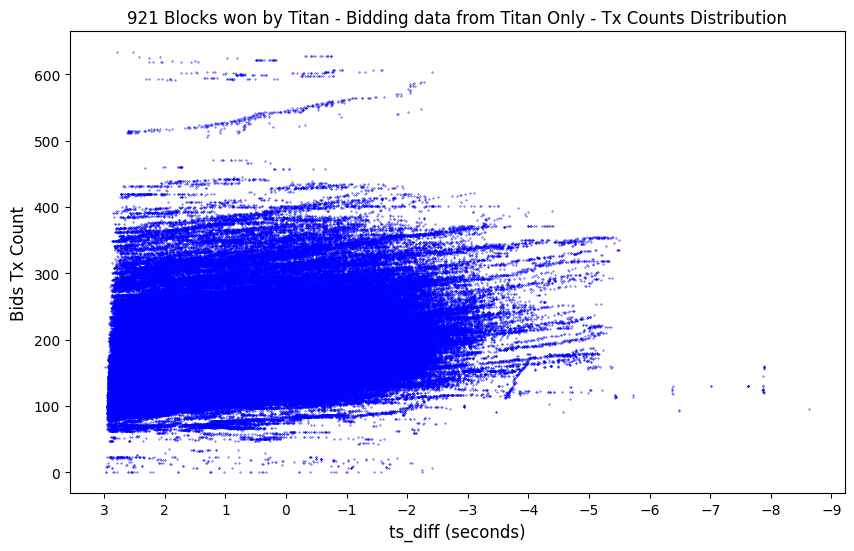

In [40]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

dft_bidding12s = dft[dft['ts_diff_secs'] > -12]

max_ts_diff_secs = dft_bidding12s['ts_diff_secs'].max()
print("all max ts_diff_secs" + str(max_ts_diff_secs))

min_ts_diff_secs = dft_bidding12s['ts_diff_secs'].min()
# print(dft_bidding12s[dft_bidding12s['ts_diff_secs'] == min_ts_diff_secs])
print("all min_ts_diff_secs" + str(min_ts_diff_secs))

# 计算 ts_diff 的最小和最大值
x_min = np.floor(dft_bidding12s['ts_diff_secs'].min())
x_max = np.ceil(dft_bidding12s['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
    dft_bidding12s['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)

dft_bidding12s.loc[:,'ts_diff_bins'] = dft_bidding12s['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))

fig, ax = plt.subplots(figsize=(10,6))
adjust_plot_x_axis(ax)
for label in dft_bidding12s['builder_label'].unique():
    dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
    ax.scatter(dft_label['ts_diff_secs'], dft_label['num_tx'], s=0.1, label=label)
    
# 获取图例并修改点的大小
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
for handle in legend.legendHandles:
    handle._sizes = [30]

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Tx Count', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from all all builders - Tx Counts Distribution')
plt.show()

# draw the scatter plot of Titan only
titan_builders = df_builder_info[df_builder_info['builder_label'].str.contains('titan', case=False, na=False)]
dft_bidding12s_titan_only = dft_bidding12s[dft_bidding12s['builder_pubkey'].isin(titan_builders['builder_pubkey'])]

max_ts_diff_secs = dft_bidding12s_titan_only['ts_diff_secs'].max()
print("max ts_diff_secs")
print(max_ts_diff_secs)
# print(dft_bidding12s_titan_only[dft_bidding12s_titan_only['ts_diff_secs'] == max_ts_diff_secs])

min_ts_diff_secs = dft_bidding12s_titan_only['ts_diff_secs'].min()
print("min ts_diff_secs")
print(min_ts_diff_secs)
# print(dft_bidding12s_titan_only[dft_bidding12s_titan_only['ts_diff_secs'] == min_ts_diff_secs])


print("all builder " + str(dft_bidding12s.shape[0]))
print("Titan " + str(dft_titan_only.shape[0]))

bx = dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='num_tx', figsize=(10,6), color='blue', s=0.1)
adjust_plot_x_axis(bx)
bx.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Tx Count', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from Titan Only - Tx Counts Distribution')

plt.show()

